In [2]:
import numpy as np
import cv2
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import joblib

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score


In [3]:
# Read the shapefile we created in last article
df = gpd.read_file('/home/jupyter-edufitimana/Data/points_data.shp')

# Check for and remove rows with no data values
df = df.dropna()
print(df.isnull().sum())


label         0
Elevation     0
Slope         0
Aspect        0
NDVI          0
NDBI          0
Drainage      0
Land cover    0
Rainfall      0
geometry      0
dtype: int64


In [23]:
# Define the dependent variable that needs to be predicted (labels)
Y = df["label"].values

# Define the independent variables. Let's also drop geometry and label
X = df.drop(labels=["label", "geometry"], axis=1) 
features_list = list(X.columns)  # List features so we can rank their importance later 

# Split data into train (80%) and validation (20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)


In [5]:
##MLP

In [20]:
from tensorflow.keras.metrics import MeanAbsoluteError

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=len(features_list), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with AUC and MAE as metrics
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc'), MeanAbsoluteError(name='mae')])


In [24]:
# Define EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model again
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=8,
                    callbacks=[early_stopping],
                    verbose=0)


In [25]:
# Predict probabilities
y_pred_prob = model.predict(X_val).ravel()

# Ensure no NaNs in predictions
print(f"NaNs in predictions: {np.isnan(y_pred_prob).sum()}")

# Compute AUC if no NaNs
if not np.isnan(y_pred_prob).any():
    test_auc = roc_auc_score(y_val, y_pred_prob)
    print(f'Test AUC: {test_auc:.2f}')
else:
    print("Prediction contains NaNs, further debugging is required.")


6/6 [==============================] - 0s 4ms/step
NaNs in predictions: 0
Test AUC: 0.90


In [26]:
from sklearn.metrics import mean_absolute_error
# Compute MAE
mae_mlp = mean_absolute_error(y_val, y_pred_prob)
print(f"MAE on the validation set: {mae_mlp:.2F}")

MAE on the validation set: 0.26


In [27]:
# Save the model
model.save('/home/jupyter-edufitimana/Data/mlp_model.h5')


In [28]:
##RF _CROSS VALI

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  mean_absolute_error, roc_auc_score, roc_curve
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the Grid Search model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_

# Make predictions on the validation set
predictions = best_rf.predict(X_val)

# Predict probabilities for MAE calculation
predicted_probabilities = best_rf.predict_proba(X_val)[:, 1]  # Probabilities for the positive class



Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [30]:
# Evaluate the model
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_val, predictions))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))


# Compute AUC
auc_rf = roc_auc_score(y_val, predicted_probabilities)
print(f"AUC on the validation set: {auc_rf:.2f}")

# Compute MAE
mae_rf = mean_absolute_error(y_val, predicted_probabilities)
print(f"MAE on the validation set: {mae_rf:.2f}")


Accuracy: 80.21%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        88
           1       0.78      0.87      0.82        99

    accuracy                           0.80       187
   macro avg       0.81      0.80      0.80       187
weighted avg       0.81      0.80      0.80       187

Confusion Matrix:
[[64 24]
 [13 86]]
AUC on the validation set: 0.88
MAE on the validation set: 0.28


In [31]:
# Save the best model to a file
joblib.dump(best_rf, '/home/jupyter-edufitimana/Data/best_random_forest_model.pkl')

['/home/jupyter-edufitimana/Data/best_random_forest_model.pkl']

In [32]:
##SVM

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

# Initialize the SVM classifier
svm_model = SVC(probability=True, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Use AUC as the scoring metric
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform GridSearchCV with AUC as the scoring metric
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring=auc_scorer, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the cross-validation results into a DataFrame
results = grid_search.cv_results_

# Convert results to a pandas DataFrame for easier plotting
df_results = pd.DataFrame(results)

# Group by 'param_C' and 'param_kernel' and calculate the mean of 'mean_test_score'
df_aggregated = df_results.groupby(['param_C', 'param_kernel'], as_index=False)['mean_test_score'].mean()

# Pivot the data to create a heatmap
pivot_table = df_aggregated.pivot(index='param_C', columns='param_kernel', values='mean_test_score')

# Fit the Grid Search model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_svm = grid_search.best_estimator_

# Make predictions and predict probabilities on the validation set
y_pred_prob = best_svm.predict_proba(X_val)[:, 1]
y_pred = best_svm.predict(X_val)


/home/jupyter-edufitimana/.local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [34]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Compute AUC
auc_svm = roc_auc_score(y_val, y_pred_prob)
print(f"ROC AUC: {auc_svm:.2f}")

# Compute MAE
mae_svm = mean_absolute_error(y_val, y_pred_prob)
print(f"Mean Absolute Error: {mae_svm:.2f}")


Accuracy: 82.35%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        88
           1       0.79      0.90      0.84        99

    accuracy                           0.82       187
   macro avg       0.83      0.82      0.82       187
weighted avg       0.83      0.82      0.82       187

Confusion Matrix:
[[65 23]
 [10 89]]
ROC AUC: 0.88
Mean Absolute Error: 0.29


In [35]:
# Save the best model to a file
joblib.dump(best_svm, '/home/jupyter-edufitimana/Data/best_svm_model.pkl')

['/home/jupyter-edufitimana/Data/best_svm_model.pkl']

In [36]:
##XGBOOST

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

# Use AUC as the scoring metric
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform GridSearchCV with AUC as the scoring metric
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring=auc_scorer, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the cross-validation results into a DataFrame
results = grid_search.cv_results_

# Convert results to a pandas DataFrame for easier plotting
df_results = pd.DataFrame(results)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_xgboost = grid_search.best_estimator_

# Make predictions and predict probabilities on the validation set
y_pred_prob = best_xgboost.predict_proba(X_val)[:, 1]
y_pred = best_xgboost.predict(X_val)


/home/jupyter-edufitimana/.local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [38]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Compute AUC
auc_xg = roc_auc_score(y_val, y_pred_prob)
print(f"ROC AUC: {auc_xg:.2f}")

# Compute MAE
mae_xg = mean_absolute_error(y_val, y_pred_prob)
print(f"Mean Absolute Error: {mae_xg:.2f}")


Accuracy: 79.68%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.77        88
           1       0.77      0.88      0.82        99

    accuracy                           0.80       187
   macro avg       0.80      0.79      0.79       187
weighted avg       0.80      0.80      0.79       187

Confusion Matrix:
[[62 26]
 [12 87]]
ROC AUC: 0.88
Mean Absolute Error: 0.29


In [39]:
# Save the best model to a file
joblib.dump(best_xgboost, '/home/jupyter-edufitimana/Data/best_xgboost_model.pkl')

['/home/jupyter-edufitimana/Data/best_xgboost_model.pkl']

In [40]:
##VISUALIZATIONS

6/6 [==============================] - 0s 3ms/step


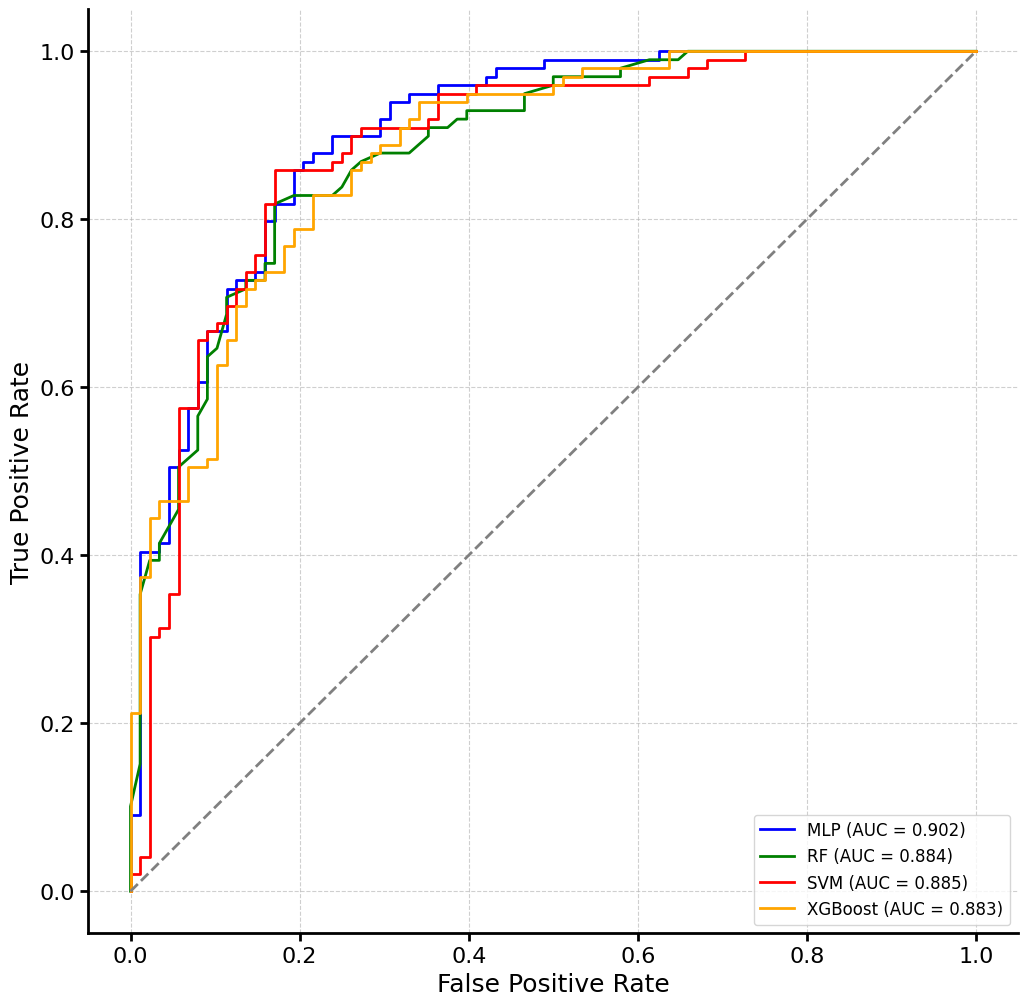

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

def compute_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    return fpr, tpr, auc_score

# For Neural Network
y_pred_prob = model.predict(X_val).ravel()

# Compute ROC curve and AUC
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_val, y_pred_prob)
auc_nn = auc(fpr_nn, tpr_nn)

# For Random Forest
fpr_rf, tpr_rf, auc_rf = compute_roc_curve(y_val, best_rf.predict_proba(X_val)[:, 1])

# For SVM
fpr_svm, tpr_svm, auc_svm = compute_roc_curve(y_val, best_svm.predict_proba(X_val)[:, 1])

# For XGBoost
fpr_xg, tpr_xg, auc_xg = compute_roc_curve(y_val, best_xgboost.predict_proba(X_val)[:, 1])

# Create the figure
plt.figure(figsize=(12, 12))

# Plot ROC curves with increased line width
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2, label=f'MLP (AUC = {auc_nn:.3f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF (AUC = {auc_rf:.3f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {auc_svm:.3f})')
plt.plot(fpr_xg, tpr_xg, color='orange', lw=2, label=f'XGBoost (AUC = {auc_xg:.3f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)

# Labels and title
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
#plt.title('ROC Curves for Different Models', fontsize=16)

# Improve the legend appearance
plt.legend(loc='lower right', fontsize=12)

# Customize axis thickness and ticks
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Make tick marks thicker and larger
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)

# Improve grid visibility
sns.despine()
plt.grid(True, linestyle='--', alpha=0.6)

# Save the figure
plt.savefig("/home/jupyter-edufitimana/Data/maps/AUCs_Kigali1.png", dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


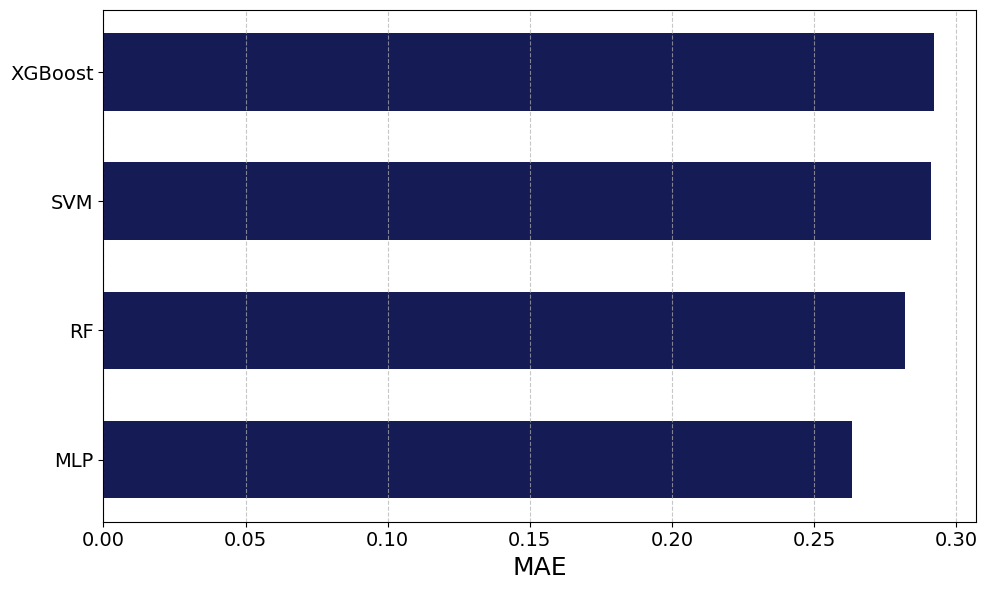

In [56]:
import matplotlib.pyplot as plt

# Model names
models = ['MLP', 'RF', 'SVM', 'XGBoost']

# MAE values
mae_values = [mae_mlp, mae_rf, mae_svm, mae_xg]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(models, mae_values, color=['#151B54', '#151B54', '#151B54', '#151B54'], height=0.6)

# Set axis labels with increased font size
ax.set_xlabel('MAE', fontsize=18)
#ax.set_title('Model Performance Comparison', fontsize=20)

# Add grid lines for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Enhance tick label size
ax.tick_params(axis='both', labelsize=14)

# Add value annotations on the bars for clarity
#for bar in bars:
    #width = bar.get_width()
    #ax.text(width + 0.02, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
            #va='center', fontsize=12, color='black')

# Style the plot
plt.tight_layout()


# Save the figure
plt.savefig("/home/jupyter-edufitimana/Data/maps/AUCs_Kigali_mae.png", dpi=600, bbox_inches='tight')


# Show the plot
plt.show()
